In [1]:
%load_ext autoreload
%autoreload 2
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256


In [2]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum, CompositionFeatures

torch.set_default_dtype(torch.float64)

In [3]:
n_test = 1000
n_train = 8000

frames = ase.io.read("data/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 8000 training frames


In [4]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 3,
    "max_radial": 6,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

# Optimization loop, energies only

In [5]:
device = "cpu"

#if torch.cuda.is_available():
#    device = "cuda"

In [6]:
train_dataset = AtomisticDataset(train_frames, all_species, HYPERS_SMALL, train_energies, radial_spectrum_n_max=8, radial_spectrum_rcut=5)
test_dataset = AtomisticDataset(test_frames, all_species, HYPERS_SMALL, test_energies, radial_spectrum_n_max=8, radial_spectrum_rcut=5)

do_gradients = False
if do_gradients is True:
    HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
    HYPERS_GRAD["gradients"] = do_gradients
    train_dataset_grad = AtomisticDataset(train_frames, all_species, HYPERS_GRAD, train_energies, train_forces, radial_spectrum_n_max=12)
    test_dataset_grad = AtomisticDataset(test_frames, all_species, HYPERS_GRAD, test_energies, test_forces, radial_spectrum_n_max=12)

In [7]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=1000,
    shuffle=True,    
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=200,
    shuffle=False,
    device=device,
)
if do_gradients is True:
    train_dataloader_grad = create_dataloader(
        train_dataset_grad,
        batch_size=50,
        shuffle=True,
        device=device,
    )

    train_dataloader_grad_no_batch = create_dataloader(
        train_dataset_grad,
        batch_size=len(train_dataset_grad),
        shuffle=False,
        device=device,
    )

    test_dataloader_grad = create_dataloader(
        test_dataset_grad,
        batch_size=50,
        shuffle=False,
        device=device,
    )

In [8]:
def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten())**2)

In [9]:
class CombinedPowerSpectrum(torch.nn.Module):
    def __init__(self, combiner):
        super().__init__()

        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()

    def forward(self, spherical_expansion):
        combined = self.combiner(spherical_expansion)

        return self.power_spectrum(combined)

        
class MultiBodyOrderModel(torch.nn.Module):
    def __init__(
        self, 
        power_spectrum,
        composition_regularizer,
        radial_spectrum_regularizer,
        power_spectrum_regularizer,        
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()

        # optimizable_weights = False is not very well tested ...
        assert optimizable_weights

        if composition_regularizer is None:
            self.composition_model = None
        else:
            self.composition_model=LinearModel(
            regularizer=composition_regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )
        
        if radial_spectrum_regularizer is None:
            self.radial_spectrum_model = None
        else:
            self.radial_spectrum_model = LinearModel(
                regularizer=radial_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        if power_spectrum_regularizer is None:
            self.power_spectrum_model = None
        else:
            self.power_spectrum = power_spectrum
            self.power_spectrum_model = LinearModel(
                regularizer=power_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        self.combiner = combiner, 
        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, composition, radial_spectrum, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)                
    
        energies, forces = None, None
        
        if self.composition_model is not None:
            energies_cmp, _ = self.composition_model(composition)
            energies = energies_cmp
            forces = None
    
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = radial_spectrum #self.sum_structure(radial_spectrum)
            energies_rs, forces_rs = self.radial_spectrum_model(radial_spectrum_per_structure, with_forces=forward_forces)
            
            if energies is None:
                energies = energies_rs  
            else:
                energies += energies_rs              
            if forces_rs is not None:
                if forces is None:
                    forces = forces_rs
                else:
                    forces += forces_rs

        if self.power_spectrum_model is not None:
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)

            energies_ps, forces_ps = self.power_spectrum_model(power_spectrum_per_structure, with_forces=forward_forces)
            if energies is None:
                energies = energies_ps
            else:
                energies += energies_ps
            if forces_ps is not None:
                if forces is None:
                    forces = forces_ps
                else:
                    forces += forces_ps
        
        return energies, forces

    def initialize_model_weights(self, composition, radial_spectrum, spherical_expansion, energies, forces=None, seed=None):
        if forces is None:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        if self.composition_model is not None:
            self.composition_model.initialize_model_weights(composition, energies, forces, seed)
        
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = self.sum_structure(radial_spectrum)
            self.radial_spectrum_model.initialize_model_weights(radial_spectrum_per_structure, energies, forces, seed)
        
        if self.power_spectrum_model is not None:        
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)
            self.power_spectrum_model.initialize_model_weights(power_spectrum_per_structure, energies, forces, seed)

In [10]:
# species combination only
N_PSEUDO_SPECIES = 4
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# N_COMBINED_RADIAL = 4
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

composition=CompositionFeatures(all_species, device=device)
power_spectrum = CombinedPowerSpectrum(combiner)

LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

model = MultiBodyOrderModel(
    power_spectrum=power_spectrum, 
    composition_regularizer=[1e-10],
    radial_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    power_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True, 
    random_initial_weights=True,
)

In [11]:
if model.optimizable_weights:
    TORCH_REGULARIZER_COMPOSITION = 1e-6
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 1e-2
    TORCH_REGULARIZER_POWER_SPECTRUM = 1e-1
else:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 0.0
    TORCH_REGULARIZER_POWER_SPECTRUM = 0.0

In [12]:
model.to(device=device, dtype=torch.get_default_dtype())

MultiBodyOrderModel(
  (sum_structure): SumStructures()
  (composition_model): LinearModel()
  (radial_spectrum_model): LinearModel()
  (power_spectrum): CombinedPowerSpectrum(
    (combiner): CombineSpecies()
    (power_spectrum): PowerSpectrum()
  )
  (power_spectrum_model): LinearModel()
)

In [13]:
if model.random_initial_weights:
    dataloader_initialization = train_dataloader_single_frame
else:
    dataloader_initialization = train_dataloader_no_batch

In [14]:
# initialize the model
with torch.no_grad():
    for composition, radial_spectrum, spherical_expansions, energies, _ in dataloader_initialization:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(composition, radial_spectrum, spherical_expansions, energies, seed=12345)
        break

del radial_spectrum, spherical_expansions

In [75]:
torch.cuda.memory_stats()['active_bytes.all.current']/1e6

KeyError: 'active_bytes.all.current'

In [38]:
torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6

KeyError: 'allocated_bytes.all.current'

In [39]:
torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6

KeyError: 'reserved_bytes.all.current'

In [57]:
lr = 0.2
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, line_search_fn="strong_wolfe", history_size=128)

In [15]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)#, line_search_fn="strong_wolfe", history_size=128)

all_losses = []

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [16]:
sum(p.detach().cpu().numpy().nbytes for p in model.parameters())
train_dataset._collatetime = 0

In [ ]:
assert model.optimizable_weights
himem = True
if himem:
    composition, radial_spectrum, spherical_expansions, energies, _ = next(iter(train_dataloader_no_batch))

for epoch in range(50):
    epoch_start = time.time()

    def single_step():
        global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        if device=="cuda":
            print(f"mem. before:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
        loss = torch.zeros(size=(1,), device=device)
        if himem:
            predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
            loss += loss_mse(predicted, energies)
        else:
            for composition, radial_spectrum, spherical_expansions, energies, _ in train_dataloader:
                try:
                    predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
                except:
                    if device=="cuda":
                        print(f"mem. during:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
                    raise
                loss += loss_mse(predicted, energies)
        loss /= n_train
        if model.composition_model is not None:
            loss += TORCH_REGULARIZER_COMPOSITION * torch.linalg.norm(model.composition_model.weights)
        if model.radial_spectrum_model is not None:
            loss += TORCH_REGULARIZER_RADIAL_SPECTRUM * torch.linalg.norm(model.radial_spectrum_model.weights)
        if model.power_spectrum_model is not None:
            loss += TORCH_REGULARIZER_POWER_SPECTRUM * torch.linalg.norm(model.power_spectrum_model.weights)

        loss.backward(retain_graph=False)
        print(loss.item(), np.linalg.norm(model.composition_model.weights.grad.numpy()))
        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        print("norms", np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.detach().cpu().numpy())
                 )
        print("gradients", 
                  np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.grad.detach().cpu().numpy())
                 )
        with torch.no_grad():
            predicted = []
            reference = []
            for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, _ in test_dataloader:
                reference.append(tenergies)
                predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            test_mae = loss_mae(predicted, reference)/n_test

            output.write(f"{n_epochs_total} {loss} {test_mae}\n")
            output.flush()

        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={test_mae:.4}")
    
    del loss
    n_epochs_total += 1

409544.30628944247 10225.353941046036
407090.2435832227 10201.143234825435
383199.6595160819 9951.836170308903
361629.1662626974 9714.092491831676
341576.4851009265 9482.126333896922
322848.9254499308 9255.028487818767
305146.2406373449 9029.981053029018
288096.60263512307 8802.464762490128
271238.7251676945 8565.657910603828
253992.4752725599 8309.325756952652
235648.6561144136 8018.265048621271
215504.35821596778 7671.692845825641
193565.58336441024 7251.422822823764
172210.9712115535 6778.632811140723
155276.76017742907 6335.6085477629995
141962.65309430475 5938.489595098649
128538.66699001587 5500.928160667458
113846.0633422807 4973.764932605248
100927.33400680282 4455.68175117079
91013.22402705242 4020.9766548009493
norms 2.1985361965629515 40.688828220196214 28.020837501945483
gradients 4020.9766548009493 3547.926158544729 15215.154777687414
epoch 0 took 353.2s, optimizer loss=4.095e+05, test mae=245.3
81606.82342751567 3579.7552767314905
71457.50744131184 3065.591735726379
62273

In [30]:
train_dataset._getitemtime

0.2913856506347656

In [31]:
train_dataset._collatetime

4.934503555297852

TEST MAE: 0.14780173353904252 eV/at


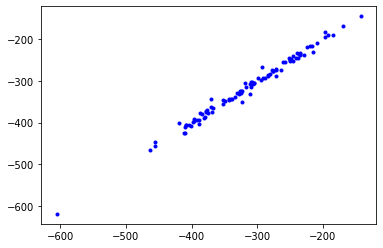

In [32]:
plt.plot(predicted.numpy(), reference.numpy(), 'b.')
print(f"TEST MAE: {test_mae.item()/len(frames[0])} eV/at")

In [33]:
with torch.no_grad():
    tpredicted = []
    treference = []
    for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, _ in train_dataloader:
        treference.append(tenergies)
        predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
        tpredicted.append(predicted_e)

    treference = torch.vstack(treference)
    tpredicted = torch.vstack(tpredicted)
    tmae = loss_mae(tpredicted, treference)/n_train

TRAIN MAE: 0.043783449765081445 eV/at


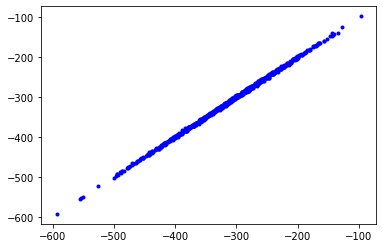

In [34]:
plt.plot(tpredicted, treference, 'b.')
print(f"TRAIN MAE: {tmae.item()/len(frames[0])} eV/at")

# Predicting forces with forward propagation

In [ ]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for frame, radial_spectrum, spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [ ]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

In [ ]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [ ]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset(
        [frame, delta_frame], 
        all_species, 
        HYPERS_GRAD, 
        torch.zeros(2, 1), 
        radial_spectrum_n_max=12,
    )
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for frame, radial_spectrum, spherical_expansions, _, _ in dataloader:
        predicted_e, predicted_f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [ ]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)